In [0]:
# !apt update
# !apt install -y cmake
# !pip install dlib

# !git clone --recursive https://github.com/microsoft/LightGBM
# %cd LightGBM
# !pwd
# !mkdir build 
# %cd /content/LightGBM/build 
# !pwd
# !cmake -DUSE_GPU=1 ..
# # if you have installed NVIDIA CUDA to a customized location, you should specify paths to OpenCL headers and library like the following:
# # cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
# !make -j4

!pip install bayesian-optimization

# !pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

In [0]:
import numpy as np
import pandas as pd
import io

import random
random.seed(28)
np.random.seed(28)

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import os
import copy
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import time
from collections import Counter
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
#import eli5
#import shap
from IPython.display import HTML
import json

import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
pd.set_option('max_rows', 500)
import re

import os

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', -1)

np.random.seed(2206)

to_drop = []
categoricals_features = []

# Read the data

In [0]:
# Local Running
# train = pd.read_csv("../data/training_v2.csv")
# samplesubmission = pd.read_csv("../data/samplesubmission.csv")
# test = pd.read_csv("../data/unlabeled.csv")
# dictionary = pd.read_csv("../data/WiDS Datathon 2020 Dictionary.csv")
# solution_template = pd.read_csv("../data/solution_template.csv")

# Colab Running

# from google.colab import drive
# drive.mount('/content/drive')

train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/training_v2.csv')
samplesubmission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/samplesubmission.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/unlabeled.csv')
dictionary = pd.read_csv('/content/drive/My Drive/Colab Notebooks/WiDS Datathon 2020 Dictionary.csv')
solution_template = pd.read_csv('/content/drive/My Drive/Colab Notebooks/solution_template.csv')

print('train ' , train.shape)
print('test ' , test.shape)
print('samplesubmission ' , samplesubmission.shape)
print('solution_template ' , solution_template.shape)
print('dictionary ' , dictionary.shape)

train  (91713, 186)
test  (39308, 186)
samplesubmission  (3, 2)
solution_template  (39308, 2)
dictionary  (188, 6)


In [0]:
dico = pd.DataFrame(dictionary.T.head(6))
dico.columns=list(dico.loc[dico.index == 'Variable Name'].unstack())
dico = dico.loc[dico.index != 'Variable Name']
dico.columns
train_stat = pd.DataFrame(train.describe())
train_stat2 = pd.concat([dico,train_stat],axis=0)
train_stat2.head(20)

,age,aids,albumin_apache,apache_2_bodysystem,apache_2_diagnosis,apache_3j_bodysystem,apache_3j_diagnosis,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,apache_post_operative,arf_apache,bilirubin_apache,bmi,bun_apache,cirrhosis,creatinine_apache,d1_albumin_max,d1_albumin_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_heartrate_max,d1_heartrate_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_resprate_max,d1_resprate_min,d1_sodium_max,d1_sodium_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,d1_wbc_max,d1_wbc_min,diabetes_mellitus,elective_surgery,encounter_id,ethnicity,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,gender,glucose_apache,h1_albumin_max,h1_albumin_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_heartrate_max,h1_heartrate_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_resprate_max,h1_resprate_min,h1_sodium_max,h1_sodium_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,h1_wbc_max,h1_wbc_min,heart_rate_apache,height,hematocrit_apache,hepatic_failure,hospital_admit_source,hospital_death,hospital_id,icu_admit_source,icu_admit_type,icu_id,icu_stay_type,icu_type,immunosuppression,intubated_apache,leukemia,lymphoma,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,patient_id,ph_apache,pre_icu_los_days,pred,readmission_status,resprate_apache,sodium_apache,solid_tumor_with_metastasis,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,weight
Category,demographic,APACHE comorbidity,APACHE covariate,APACHE grouping,APACHE covariate,APACHE grouping,APACHE covariate,APACHE prediction,APACHE prediction,APACHE covariate,APACHE covariate,APACHE covariate,demographic,APACHE covariate,APACHE comorbidity,APACHE covariate,labs,labs,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs,labs,labs,labs,labs,labs,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,labs,labs,labs,labs,vitals,vitals,labs,labs,labs,labs,labs,labs,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,labs blood gas,labs blood gas,labs,labs,labs,labs,vitals,vitals,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,labs,labs,APACHE comorbidity,demographic,identifier,demographic,APACHE covariate,APACHE covariate,APACHE covariate,APACHE covariate,APACHE covariate,demographic,APACHE covariate,labs,labs,labs blood gas,labs blood gas,labs blood gas,labs blood gas

# OverView of the dataset

In [0]:
train_stat2.T.head(200)

,Category,Unit of Measure,Data Type,Description,Example,count,mean,std,min,25%,50%,75%,max
age,demographic,Years,numeric,The age of the patient on unit admission,None,"87,485.00",62.31,16.78,16.00,52.00,65.00,75.00,89.00
aids,APACHE comorbidity,None,binary,Whether the patient has a definitive diagnosis of acquired immune deficiency syndrome (AIDS) (not HIV positive alone),1,"90,998.00",0.00,0.03,0.00,0.00,0.00,0.00,1.00
albumin_apache,APACHE covariate,g/L,numeric,The albumin concentration measured during the first 24 hours which results in the highest APACHE III score,30,"37,334.00",2.90,0.68,1.20,2.40,2.90,3.40,4.60
apache_2_bodysystem,APACHE grouping,None,string,Admission diagnosis group for APACHE II,Respiratory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apache_2_diagnosis,APACHE covariate,None,string,The APACHE II diagnosis for the ICU admission,308,"90,051.00",185.40,86.05,101.00,113.00,122.00,301.00,308.00
apache_3j_bodysystem,APACHE grouping,None,string,Admission diagnosis group for APACHE III,Cardiovascular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apache_3j_diagnosis,APACHE covariate,None,string,The APACHE III-J sub-diagnosis code which best describes the reason for the ICU admission,1405,"90,612.00",558.22,463.27,0.01,203.01,409.02,703.03,"2,201.05"
apache_4a_hospital_death_prob,APACHE prediction,None,numeric,"The APACHE IVa probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.",0.31,"83,766.00",0.09,0.25,-1.00,0.02,0.05,0.13,0.99
apache_4a_icu_death_prob,APACHE prediction,None,numeric,"The APACHE IVa probabilistic prediction of in ICU mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis",0.24,"83,766.00",0.04,0.22,-1.00,0.01,0.02,0.06,0.97
apache_post_operative,APACHE covariate,None,binary,"The APACHE operative status; 1 for post-operative, 0 for non-operative",1,"91,713.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00


## EDA

In [0]:
# Missing Values
train.isna().sum()

encounter_id                     0    
patient_id                       0    
hospital_id                      0    
hospital_death                   0    
age                              4228 
bmi                              3429 
elective_surgery                 0    
ethnicity                        1395 
gender                           25   
height                           1334 
hospital_admit_source            21409
icu_admit_source                 112  
icu_id                           0    
icu_stay_type                    0    
icu_type                         0    
pre_icu_los_days                 0    
readmission_status               0    
weight                           2720 
albumin_apache                   54379
apache_2_diagnosis               1662 
apache_3j_diagnosis              1101 
apache_post_operative            0    
arf_apache                       715  
bilirubin_apache                 58134
bun_apache                       19262
creatinine_apache        

## Functions

In [0]:
# function to evaluate the score of our model
def eval_auc(pred,real):
    false_positive_rate, recall, thresholds = roc_curve(real, pred)
    roc_auc = auc(false_positive_rate, recall)
    return roc_auc    

In [0]:
# a wrapper class  that we can have the same ouput whatever the model we choose
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'hospital_death'
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.y_pred, self.score, self.model , self.oof_pred = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits

            print('Partial score of fold {} is: {}'.format(fold,eval_auc(oof_pred[val_idx],y_val) ))
        #print(oof_pred, self.train_df[self.target].values)
        loss_score = eval_auc(oof_pred,self.train_df[self.target].values) 
        if self.verbose:
            print('Our oof AUC score is: ', loss_score)
        return y_pred, loss_score, model , oof_pred

In [0]:
#we choose to try a LightGbM using the Base_Model class
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set   = lgb.Dataset(x_val,    y_val,  categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                  'boosting_type': 'gbdt',
                  'objective': 'binary',
                  'metric': 'auc',
                  'subsample': 0.75,
                  'subsample_freq': 1,
                  'learning_rate': 0.1,
                  'feature_fraction': 0.9,
                  'max_depth': 15,
                  'lambda_l1': 1,  
                  'lambda_l2': 1,
                  'early_stopping_rounds': 100,
                  #'is_unbalance' : True ,
                  'scale_pos_weight' : 3,
                  # 'device': 'gpu',
                  # 'gpu_platform_id': 0,
                  # 'gpu_device_id': 0,
                  'num_leaves': 31
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['scale_pos_weight']=ps['scale_pos_weight']
            params['max_depth']=int(ps['max_depth'])
            params['subsample']=ps['subsample']
            params['num_leaves']=int(ps['num_leaves'])
            params['min_split_gain']=ps['min_split_gain']
#             params['min_child_weight']=ps['min_child_weight']
        
        return params  

In [0]:
def plot_importances(importances_, plot_name):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('{}.png'.format(plot_name))
    plt.show()

## Pre Processing

In [0]:
# Replace values

print('Replacing: {}'.format('hospital_admit_source'))
replace_hospital_admit_source =  {'Other ICU': 'ICU',
                                  'ICU to SDU':'SDU', 
                                  'Step-Down Unit (SDU)': 'SDU', 
                                  'Other Hospital':'Other',
                                  'Observation': 'Recovery Room',
                                  'Acute Care/Floor': 'Acute Care'}
train['hospital_admit_source'].replace(replace_hospital_admit_source, inplace=True)
test['hospital_admit_source'].replace(replace_hospital_admit_source, inplace=True)


print('Replacing: {}'.format('icu_type'))
replace_icu_type = {'CCU-CTICU': 'Grpd_CICU', 
                    'CTICU':'Grpd_CICU', 
                    'Cardiac ICU':'Grpd_CICU'}
train['icu_type'] = train['icu_type'].replace(replace_icu_type, inplace=True)
test['icu_type'] = test['icu_type'].replace(replace_icu_type, inplace=True)


print('Replacing: {}'.format('apache_2_bodysystem'))
replace_apache_2_bodysystem = {'Undefined diagnoses': 'Undefined Diagnoses'}
train['apache_2_bodysystem'].replace(replace_apache_2_bodysystem, inplace=True)
test['apache_2_bodysystem'].replace(replace_apache_2_bodysystem, inplace=True)


print('Replacing: {}'.format('apache_4a_hospital_death_prob'))
# train['apache_4a_hospital_death_prob'].fillna(np.nan, inplace=True) # transform every nan value to np.nan
# test['apache_4a_hospital_death_prob'].fillna(np.nan, inplace=True)
train['apache_4a_hospital_death_prob'].fillna(0, inplace=True) # transform every nan value to 0
test['apache_4a_hospital_death_prob'].fillna(0, inplace=True)
replace_apache_4a_hospital_death_prob = {-1: 0}
train['apache_4a_hospital_death_prob'].replace(replace_apache_4a_hospital_death_prob, inplace=True) # transform all -1 to 0
test['apache_4a_hospital_death_prob'].replace(replace_apache_4a_hospital_death_prob, inplace=True)


print('Replacing: {}'.format('apache_4a_icu_death_prob'))
# train['apache_4a_icu_death_prob'].fillna(np.nan, inplace=True) # transform every nan value to np.nan
# test['apache_4a_icu_death_prob'].fillna(np.nan, inplace=True)
train['apache_4a_icu_death_prob'].fillna(0, inplace=True) # transform every nan value to 0
test['apache_4a_icu_death_prob'].fillna(0, inplace=True)
replace_apache_4a_icu_death_prob = {-1: 0}
train['apache_4a_icu_death_prob'].replace(replace_apache_4a_icu_death_prob, inplace=True) # transform all -1 to 0
test['apache_4a_icu_death_prob'].replace(replace_apache_4a_icu_death_prob, inplace=True)

Replacing: hospital_admit_source
Replacing: icu_type
Replacing: apache_2_bodysystem
Replacing: apache_4a_hospital_death_prob
Replacing: apache_4a_icu_death_prob


In [0]:
# BMI missing values/Weight classification

# Convert to cm
train['height'] = train['height']/100
test['height'] = test['height']/100

# BMI formula
train['bmi'] = train['weight']/(train['height']**2)

# classifiy weight class
def weighted_classt(x): 
    if pd.isna(x):
        return np.nan
    elif x < 15: 
        return 'very severely underweight' 
    elif x >= 15 and x < 16: 
        return 'severely weight' 
    elif x >=16 and x < 18.5: 
        return 'underweight' 
    elif x >= 18.5 and x < 25: 
        return 'healthy weight' 
    elif x >= 25 and x < 30: 
        return 'overweight'
    elif x >= 30 and x < 35: 
        return 'class 1' 
    elif x >= 35 and x < 40: 
        return 'class 2' 
    else: 
        return 'class 3' 
   
train['weightclass'] = train['bmi'].map(weighted_classt)
test['weightclass'] = test['bmi'].map(weighted_classt)

to_drop = to_drop + ['bmi']
categoricals_features = categoricals_features + ['weightclass']

In [0]:
# Dropping column's with single value and all unique values

for col in train.columns:
    if train[col].nunique() == 1:
        print('With only 1 unique value: ', col)
    if train[col].nunique() == train.shape[0]:
        print('With all unique value: ', col)

print('\nDropping readmission_status')
#train = train.drop(['readmission_status'], axis=1)
to_drop = ['readmission_status']

With all unique value:  encounter_id
With all unique value:  patient_id
With only 1 unique value:  readmission_status

Dropping readmission_status


In [0]:
# # threshold for removing correlated variables
# threshold = 0.9

# # Absolute value correlation matrix
# corr_matrix = train.corr().abs()
# # corr_matrix.head()

# # Upper triangle of correlations
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# upper.head()

# # Select columns with correlations above threshold
# to_drop_threshold = [column for column in upper.columns if any(upper[column] > threshold)]
# print(to_drop_threshold)
# print('There are {} columns to remove.'.format(len(to_drop_threshold)))
# #Drop the columns with high correlations
# to_drop = list(set(to_drop + to_drop_threshold))

# len(to_drop)

In [0]:
#we are going to drop these columns because we dont want our ML model to be bias toward these consideration
#(we also remove the target and the ids.)
#to_drop = to_drop + ['gender','ethnicity' ,'encounter_id', 'patient_id',  'hospital_death']
to_drop = to_drop + ['ethnicity' ,'encounter_id', 'patient_id',  'hospital_death']


# this is a list of features that look like to be categorical
categoricals_features = categoricals_features + ['hospital_id','ethnicity','gender','hospital_admit_source','icu_admit_source',
                         'icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']
                         #'apache_2_diagnosis', 'apache_3j_diagnosis']
categoricals_features = [col for col in categoricals_features if col not in to_drop]

# features with zero importance
#to_drop = to_drop + ['lymphoma']

# this is the list of all input feature we would like our model to use 
features = [col for col in train.columns if col not in to_drop ]
print('numerber of features ' , len(features))
print('shape of train / test ', train.shape , test.shape)

numerber of features  182
shape of train / test  (91713, 187) (39308, 187)


categorical feature need to be transform to numeric for mathematical purpose.
different technics of categorical encoding exists here we will rely on our model API to deal with categorical
still we need to encode each categorical value to an id , for this purpose we use LabelEncoder


In [0]:
# categorical feature need to be transform to numeric for mathematical purpose.
# different technics of categorical encoding exists here we will rely on our model API to deal with categorical
# still we need to encode each categorical value to an id , for this purpose we use LabelEncoder

print('Transform all String features to category.\n')
for usecol in categoricals_features:
    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1
    
    train[usecol] = train[usecol].replace(np.nan, 0).astype('int').astype('category')
    test[usecol]  = test[usecol].replace(np.nan, 0).astype('int').astype('category')
    
print('Finish')

Transform all String features to category.

Finish


In [0]:
## Imputation
# Imputing missing values in continuous columns by Median
# I am considering high cardinality columns as continuous columns only
# Imputing missing values in categorical columns by Mode
# https://www.kaggle.com/kuldeep7688/xgboost-parameter-tuning-baseline

from sklearn.impute import SimpleImputer
from tqdm import tqdm_notebook

continuous_columns = list(set([
    'd1_spo2_max', 'd1_diasbp_max', 'd1_temp_min', 'h1_sysbp_max', 'heart_rate_apache', 
    'weight', 'd1_mbp_max', 'h1_resprate_max', 'd1_heartrate_min', 'apache_4a_hospital_death_prob', 
    'd1_mbp_min', 'apache_4a_icu_death_prob', 'd1_sysbp_max', 'h1_sysbp_min', 'h1_resprate_min', 'd1_resprate_max', 
    'h1_mbp_min', 'resprate_apache', 'map_apache', 'temp_apache', 'h1_spo2_min', 
    'd1_spo2_min', 'd1_resprate_min', 'h1_mbp_max', 'height', 'age', 'h1_diasbp_max', 'd1_sysbp_min',
    'pre_icu_los_days', 'd1_heartrate_max', 'd1_diasbp_min', 'gcs_eyes_apache', 
    'gcs_motor_apache', 'd1_temp_max', 'h1_spo2_max', 'h1_heartrate_max', 'bmi', 'd1_glucose_min', 
    'h1_heartrate_min', 'gcs_verbal_apache', 'd1_glucose_max', 'h1_diasbp_min']))

# # binary_columns = list(set([
# #     "apache_post_operative", "arf_apache", "cirrhosis", "diabetes_mellitus", "immunosuppression",
# #     "hepatic_failure", "leukemia", "lymphoma", "solid_tumor_with_metastasis", "gcs_unable_apache",
# #     "intubated_apache", "ventilated_apache"]))

# # # for categorical
# # # cat_col2imputer_mapping = {
# # #     col: SimpleImputer(strategy='most_frequent')
# # #     for col in categoricals_features}

# for continuous
cont_col2imputer_mapping = {
    col: SimpleImputer(strategy='median')
    for col in continuous_columns}

# # # for binary 
# # bin_col2imputer_mapping = {
# #     col: SimpleImputer(strategy='most_frequent')
# #     for col in binary_columns}

# # all_imp_dicts = [cat_col2imputer_mapping]
all_imp_dicts = [cont_col2imputer_mapping]#, bin_col2imputer_mapping]

# fitting imputers
for imp_mapping_obj in tqdm_notebook(all_imp_dicts):
    for col, imp_object in imp_mapping_obj.items():
        data = train[col].values.reshape(-1, 1)
        imp_object.fit(data)

# transofrming imputed columns
# fitting imputers
for imp_mapping_obj in tqdm_notebook(all_imp_dicts):
    for col, imp_object in imp_mapping_obj.items():
        data = train[col].values.reshape(-1, 1)
        data = imp_object.transform(data)
        train[col] = list(data.reshape(-1,))

# inputing on test 
for imp_mapping_obj in tqdm_notebook(all_imp_dicts):
    for col, imp_object in imp_mapping_obj.items():
        data = test[col].values.reshape(-1, 1)
        data = imp_object.transform(data)
        test[col] = list(data.reshape(-1,))

# Drop all missing Values
# obs: 
# we delete a particular row if it has a null value for a particular feature. 
# This method is used only when there are enough samples in the data set. 
# It has to be ensured that there is no bias after data deletion. 
# Removing the data will lead to loss of information which will not give the expected results while predicting
# the output.

print('Train Dataset: ')
print("Orginal shape before dropna()" ,train.shape)
train = train.dropna()
print("Shape after dropna()" ,train.shape)

print('\n\n')
print('Test Dataset: ')
print("Orginal shape before dropna()" ,test.shape)
test = test.dropna()
print("Shape after dropna()" ,test.shape)

# Drop the values above a certain threshold
# If the information contained in the variable is not that high, you can drop the variable 
# if it has more than 50% missing values. In this method we are dropping columns with null values above a 
# certain threshold

# threshold = len(train) * 0.60
threshold = len(train) * 0.50

df_train_thresh = train.dropna(axis=1, thresh=threshold)

# View columns in the dataset
display(df_train_thresh.shape)

print('Columns that were removed:')
remove_with_threshold = list(set(train.columns) - set(df_train_thresh.columns))
display(remove_with_threshold)

# this is the NEW list of all input feature we would like our model to use 
features = [col for col in features if col not in remove_with_threshold]

print(len(features))

del df_train_thresh, remove_with_threshold

## Adversarial Validation

The main idea of adversarial validation is to detect shift/drift in the different features between 2 datasets.

We usually train a model on past data to forecast future data so it can happened that these futures datas have a distribution that is no longer in line with the data we used for training, or maybe we train on some hospital datas and apply our model on other hospital ?

You can detect drift by statistical test (like t-test) but here we will do it by training a machine learning model and check if the model can figure out if the data is from the train or test set. If it can, this means that the test data comes from another distribution compare to the train data and then you have to check the distribution of the most important features that are likely to be different between train and test.

In [0]:
# def adversarial_validation(train, test, features):
#     tr_data   = train.copy()
#     tst_data = test.copy()
#     tr_data['target']  = 0 
#     tst_data['target'] = 1
#     av_data = pd.concat([tr_data, tst_data], axis = 0)
#     av_data.reset_index(drop = True)        
#     params = {
#             'learning_rate': 0.1, 
#             'seed': 50,
#             'objective':'binary',
#             'boosting_type':'gbdt',
#             'metric': 'auc',
#         }    
#     # define a KFold strategy
#     kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
#     target = 'target'
#     oof_pred = np.zeros(len(av_data))
#     important_features = pd.DataFrame()
#     fold_auc = []    
    
#     for fold, (tr_ind, val_ind) in enumerate(kf.split(av_data, av_data[target])) :
#         print('Fold {}'.format(fold + 1))
#         x_train, x_val = av_data[features].iloc[tr_ind], av_data[features].iloc[val_ind]
#         y_train, y_val = av_data[target].iloc[tr_ind], av_data[target].iloc[val_ind]
#         train_set = lgb.Dataset(x_train, y_train)
#         val_set   = lgb.Dataset(x_val, y_val)
        
#         model = lgb.train(params, train_set, num_boost_round = 1000, early_stopping_rounds = 20, valid_sets = [train_set, val_set], verbose_eval = 100)
        
#         fold_importance = pd.DataFrame()
#         fold_importance['feature'] = features
#         fold_importance['gain'] = model.feature_importance()
#         important_features = pd.concat([important_features, fold_importance], axis = 0)
        
#         oof_pred[val_ind] = model.predict(x_val)
#         fold_auc.append(metrics.roc_auc_score(y_train, model.predict(x_train)))
        
#     print('Our mean train roc auc score is :', np.mean(fold_auc))
#     print('Our oof roc auc score is :', metrics.roc_auc_score(av_data[target], oof_pred))
#     return important_features

In [0]:
# def plot_differente_between_train_test(adversarial_features):
#     import warnings
#     warnings.filterwarnings("ignore")
#     warnings.simplefilter(action='ignore', category=UserWarning)
#     i=0
#     for index, row in adversarial_features.sort_values(by=['gain'],ascending=False).iterrows():  
#         column=row['feature']
#         if i< 10:
#                 print(column,i,"gain :",row['gain'])
#                 df1      = train.copy()
#                 df2      = test.copy()

#                 fig = plt.figure(figsize=(20,4))
#                 sns.distplot(df1[column].dropna(),  color='yellow', label='train', kde=True); 
#                 sns.distplot(df2[column].dropna(),  color='violet', label='test', kde=True); 
#                 fig=plt.legend(loc='best')
#                 plt.xlabel(column, fontsize=12);
#                 plt.show()
#                 i=i+1

In [0]:
# # run the adversatial model with all the feature we used :
    
# adversarial_features = adversarial_validation(train, test, features)

# # AUC is almost perfect so we can expect that some feature are perfectly different between train / test

# adversarial_features = adversarial_features[['gain', 'feature']].groupby('feature').mean().reset_index()
# adversarial_features= adversarial_features.sort_values('gain', ascending=False)

# plot_importances(adversarial_features, 'importances-lgb-v6')

# # So icu_id columns seems to be the feature that dominate the feature importance for the adversarial 
# # validation model, so it is likely to be totally different between train and test, 
# # lets check the distribution of the top features :

# plot_differente_between_train_test(adversarial_features)

In [0]:
# # it is .... Let's remove icu_id and see the results ..
# adversarial_features2 = adversarial_validation(train, test, [ f for f in features if f not in ['icu_id'] ])

# # Let`s check again the difference between train / test

# adversarial_features2 = adversarial_features2[['gain', 'feature']].groupby('feature').mean().reset_index()
# adversarial_features2= adversarial_features2.sort_values('gain', ascending=False)

# plot_importances(adversarial_features2, 'importances-lgb-v6')

# plot_differente_between_train_test(adversarial_features2)

In [0]:
# # hospital_id seems to be also from a different distribution. 
# # We can check it directly, obviously only few hospital are common to both dataset ..

# common_id  = list([id for id in train['hospital_id'].unique() if id in test['hospital_id'].unique() ])
# id_only_in_train  = [id for id in train['hospital_id'].unique() if id not in test['hospital_id'].unique() ]
# id_only_in_test   = [id for id in test['hospital_id'].unique()  if id not in train['hospital_id'].unique() ]
# count_common_train = train.loc[train['hospital_id'].isin(common_id)].shape[0]
# count_common_test  = test.loc[test['hospital_id'].isin(common_id)].shape[0]

# count_train = train.loc[train['hospital_id'].isin(id_only_in_train)].shape[0]
# count_test  = test.loc[test['hospital_id'].isin(id_only_in_test)].shape[0]

 
# fig = plt.figure(figsize=(20,6))
# venn2(subsets = (count_train,  count_test, count_common_train+count_common_test), set_labels = ('Hospital only in train', 'Hospital only in test'),set_colors=('purple', 'yellow'), alpha = 0.7);
# plt.show()

In [0]:
# # Let's do an ultimate try without 'icu_id','hospitaadversarial_features3 = adversarial_validation(train, test, [ f for f in features if f not in ['icu_id','hospital_id'] ])l_id'
# adversarial_features3 = adversarial_validation(train, test, [ f for f in features if f not in ['icu_id','hospital_id'] ])

# # I leave it to you to see what you can do with other features..
# adversarial_features3 = adversarial_features3[['gain', 'feature']].groupby('feature').mean().reset_index()
# adversarial_features3= adversarial_features3.sort_values('gain', ascending=False)

# plot_importances(adversarial_features3, 'importances-lgb-v6')

# plot_differente_between_train_test(adversarial_features3)

In [0]:
# # Let's do an ultimate try without 'icu_id','hospital_id', 'urineoutput_apache'
# adversarial_features4 = adversarial_validation(train, test, [ f for f in features if f not in ['icu_id','hospital_id', 'urineoutput_apache'] ])

# # Let`s check again the difference between train / test
# adversarial_features4 = adversarial_features4[['gain', 'feature']].groupby('feature').mean().reset_index()
# adversarial_features4 = adversarial_features4.sort_values('gain', ascending=False)

# plot_importances(adversarial_features4, 'importances-lgb-v6')

# plot_differente_between_train_test(adversarial_features4)

In [0]:
# Lets remove hospital_id, icu_id and urineoutput_apache

print('Difference between train and teste> -- hospital_id: ')
print(len(list(set(train['hospital_id']) - set(test['hospital_id']))))

print('\nDifference between train and teste> -- icu_id: ')
print(len(list(set(train['icu_id']) - set(test['icu_id']))))

print('\nDifference between train and teste> -- urineoutput_apache: ')
print(len(list(set(train['urineoutput_apache']) - set(test['urineoutput_apache']))))


# Drop features with zero importance
print('\nLength train features: {}'.format(len(features)))
for feat_to_remove in ['icu_id', 'hospital_id']:#, 'urineoutput_apache']:
    if feat_to_remove in categoricals_features:
        print('Removing from categoricals_features....{}'.format(feat_to_remove))
        categoricals_features.remove(feat_to_remove)
    if feat_to_remove in features:
        print('Removing from features....{}'.format(feat_to_remove))
        features.remove(feat_to_remove)
    
print('\nNew length train features: {}'.format(len(features)))

Difference between train and teste> -- hospital_id: 
138

Difference between train and teste> -- icu_id: 
229

Difference between train and teste> -- urineoutput_apache: 
64139

Length train features: 182
Removing from features....icu_id
Removing from categoricals_features....hospital_id
Removing from features....hospital_id

New length train features: 180


# Model

In [0]:
# percentage of death , hopefully it s a bit unbalanced
train['hospital_death'].sum()/train['hospital_death'].count()

0.08630183289173836

# Hyper parameter tuning

In [0]:
# You want Bayesian Optimization?

# boll_BayesianOptimization = False
boll_BayesianOptimization = True

In [0]:
%time

def LGB_Beyes(
              subsample_freq,
              learning_rate,
              feature_fraction,
              max_depth,
              lambda_l1,
              lambda_l2,
              scale_pos_weight,
              subsample,
              num_leaves,
              min_split_gain):
            # min_child_weight):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['scale_pos_weight']=scale_pos_weight
    params['subsample']=subsample
    params['num_leaves']=num_leaves
    params['min_split_gain']=min_split_gain
  #  params['min_child_weight']=min_child_weight
    
    
    lgb_model= Lgb_Model(train, test, features, categoricals=categoricals_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'max_depth': (5, 17),
    'subsample': (0.5, 1),
    'num_leaves': (10, 45),
    'feature_fraction': (0.1, 1),
    'min_split_gain': (0.0, 0.1),
#     'min_child_weight': (1e-3, 50),
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'scale_pos_weight': (1, 10)
}

# ACTIVATE it if you want to search for better parameter
if boll_BayesianOptimization: 
    LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 23
    n_iter = 23
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

Streaming output truncated to the last 5000 lines.
Early stopping, best iteration is:
[1862]	training's auc: 0.96877	valid_1's auc: 0.908067
Partial score of fold 1 is: 0.9080670670021724
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.904393	valid_1's auc: 0.883503
[200]	training's auc: 0.912708	valid_1's auc: 0.889395
[300]	training's auc: 0.919011	valid_1's auc: 0.892883
[400]	training's auc: 0.924556	valid_1's auc: 0.895256
[500]	training's auc: 0.929455	valid_1's auc: 0.897183
[600]	training's auc: 0.933877	valid_1's auc: 0.898518
[700]	training's auc: 0.937981	valid_1's auc: 0.899663
[800]	training's auc: 0.941897	valid_1's auc: 0.900582
[900]	training's auc: 0.945413	valid_1's auc: 0.901294
[1000]	training's auc: 0.948595	valid_1's auc: 0.901776
[1100]	training's auc: 0.951597	valid_1's auc: 0.90217
[1200]	training's auc: 0.954452	valid_1's auc: 0.902521
[1300]	training's auc: 0.957111	valid_1's auc: 0.9029
[1400]	training's auc: 0.959577	v

In [0]:
if boll_BayesianOptimization and LGB_BO:
  print(LGB_BO.max['params'])

{'feature_fraction': 0.27009840650216227, 'lambda_l1': 2.6808076863670545, 'lambda_l2': 2.7691150265600446, 'learning_rate': 0.007597467171630429, 'max_depth': 16.802741778571566, 'min_split_gain': 0.019179566635200165, 'num_leaves': 44.60173764360089, 'scale_pos_weight': 1.7439631886952076, 'subsample': 0.7578258843367845, 'subsample_freq': 1.7400888854193735}


In [0]:
# params = {'feature_fraction': 0.9,
#  'lambda_l1': 1,
#  'lambda_l2': 1,
#  'learning_rate': 0.1,
#  'max_depth': 13,
#  'subsample_freq': 1,
#  'scale_pos_weight':1}

# Best Hyperparams from Bayesian Optimization in notebook lgb-v2
# params = {'feature_fraction': 0.524207414205945,
#  'lambda_l1': 4.171808735757517,
#  'lambda_l2': 4.6435328298317256,
#  'learning_rate': 0.007897539397989824,
#  'max_depth': 16.62053004755999,
#  'scale_pos_weight': 1.2199266532301127,
#  'subsample_freq': 1.0276518730971627}


# # Best Hyperparams from Bayesian Optimization in notebook lgb-v3
# params = {'feature_fraction': 0.524207414205945,
#  'lambda_l1': 4.171808735757517,
#  'lambda_l2': 4.6435328298317256,
#  'learning_rate': 0.007897539397989824,
#  'max_depth': 16.62053004755999,
#  'scale_pos_weight': 1.2199266532301127,
#  'subsample_freq': 1.0276518730971627}

# # Best Hyperparams from Bayesian Optimization in notebook lgb-v4
# params = {'feature_fraction': 0.524207414205945,
# {'feature_fraction': 0.5348508368206359,
#  'lambda_l1': 0.0009370993396629057,
#  'lambda_l2': 4.743745312344983,
#  'learning_rate': 0.012891827059322746,
#  'max_depth': 15.784155449197529,
#  'scale_pos_weight': 1.0325760631926175,
#  'subsample_freq': 1.0744384574974872}

# # Best Hyperparams from Bayesian Optimization in notebook lgb-v5
# params = {'feature_fraction': 0.3245039721724266,
#  'lambda_l1': 1.416727346446085,
#  'lambda_l2': 2.779776916582821,
#  'learning_rate': 0.006854369969433722,
#  'max_depth': 16.673905691676964,
#  'min_split_gain': 0.05643417986130283,
#  'num_leaves': 44.8672896759208,
#  'scale_pos_weight': 1.1577974342088542,
#  'subsample': 0.630352165410007,
#  'subsample_freq': 1.2158674819047501}

# Best Hyperparams from Bayesian Optimization in notebook lgb-v6
params = {
   'feature_fraction':0.1743912077888097,
   'lambda_l1':2.838660318794291,
   'lambda_l2':0.292397357257721,
   'learning_rate':0.012602188092427687,
   'max_depth':16.575351761228106,
   'min_split_gain':0.04631934372471113,
   'num_leaves':44.81666226482246,
   'scale_pos_weight':1.0897617979884857,
   'subsample':0.8260779721854892,
   'subsample_freq':1.2473380372944387}

# Best Hyperparams from Bayesian Optimization in notebook lgb-v7
# params = {'feature_fraction': 0.30771790276874433, 
#            'lambda_l1': 2.3028038231546493, 
#            'lambda_l2': 3.2967751716954288, 
#            'learning_rate': 0.00502754922171798, 
#            'max_depth': 6.970636877380469, 
#            'min_split_gain': 0.07604566839304278, 
#            'num_leaves': 44.72702232184403, 
#            'scale_pos_weight': 1.131931435861181,
#            'subsample': 0.7821959460560016, 
#            'subsample_freq': 1.7368184403039577}

In [0]:
%time

if boll_BayesianOptimization: # ACTIVATE it if you want to search/use for better parameter
# if False:
    print('Using Bayesian Optimization params')
    lgb_model = Lgb_Model(train,test, features, categoricals=categoricals_features, ps= LGB_BO.max['params'])
else :
    lgb_model = Lgb_Model(train,test, features, categoricals=categoricals_features, ps=params)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
Using Bayesian Optimization params
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.905751	valid_1's auc: 0.890887
[200]	training's auc: 0.91277	valid_1's auc: 0.894377
[300]	training's auc: 0.918876	valid_1's auc: 0.897469
[400]	training's auc: 0.924079	valid_1's auc: 0.899822
[500]	training's auc: 0.928848	valid_1's auc: 0.901768
[600]	training's auc: 0.933344	valid_1's auc: 0.903134
[700]	training's auc: 0.93744	valid_1's auc: 0.904336
[800]	training's auc: 0.941284	valid_1's auc: 0.905177
[900]	training's auc: 0.944788	valid_1's auc: 0.90575
[1000]	training's auc: 0.948128	valid_1's auc: 0.906326
[1100]	training's auc: 0.951198	valid_1's auc: 0.906805
[1200]	training's auc: 0.954092	valid_1's auc: 0.907077
[1300]	training's auc: 0.95697	valid_1's auc: 0.907211
[1400]	training's auc: 0.959594	valid_1's auc: 0.907532
[1500]	training's auc: 0.962071	valid_1's auc: 0.907726
[1600]	trai

In [0]:
para aqui

SyntaxError: ignored

Feature Importance from the lightgbm model (gain)

In [0]:
imp_df = pd.DataFrame()
imp_df['feature'] = features
imp_df['gain']  = lgb_model.model.feature_importance(importance_type='gain')
imp_df['split'] = lgb_model.model.feature_importance(importance_type='split')

In [0]:
imp_df.sort_values(ascending=True, by='gain').reset_index()

,index,feature,gain,split
0,175,lymphoma,0.00,0
1,8,icu_type,0.00,0
2,174,leukemia,14.46,2
3,169,aids,37.47,1
4,172,hepatic_failure,60.79,7
5,170,cirrhosis,79.53,6
6,27,intubated_apache,310.43,12
7,15,arf_apache,378.32,46
8,7,icu_stay_type,406.89,42
9,123,h1_bilirubin_max,461.39,57


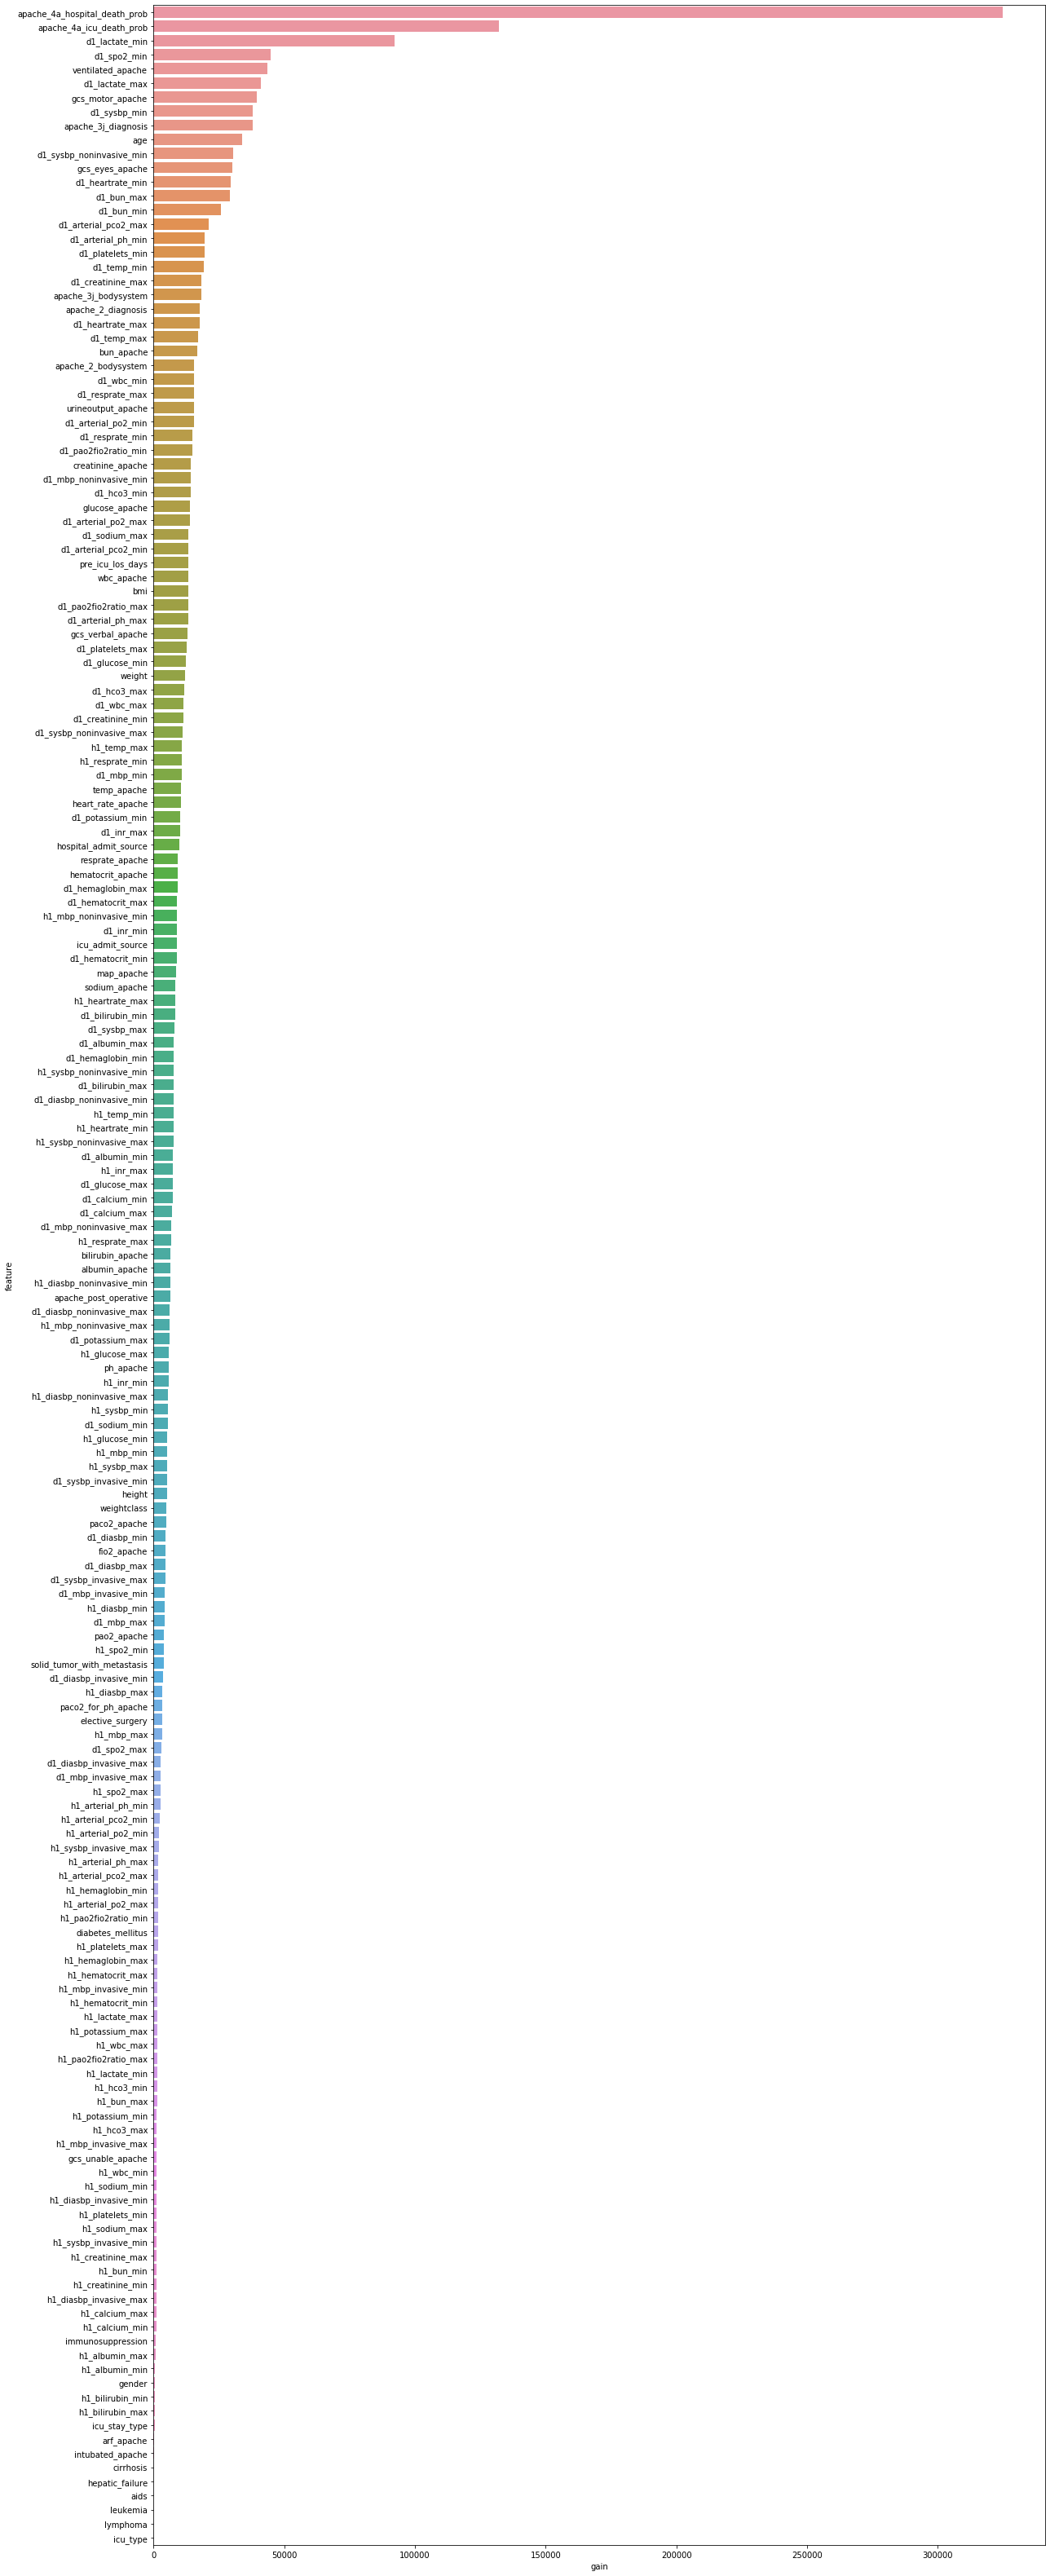

In [0]:
plot_importances(imp_df, 'importances-lgb-v7-lgb_model')

# Feature Importance by permutation importance algo

In [0]:
# import shap
# explainer   =  shap.TreeExplainer(lgb_model.model)
# shap_values = explainer.shap_values(train[features].iloc[:1000,:])
# shap.summary_plot(shap_values, train[features].iloc[:1000,:])

# Some univariate plot of the best feature

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in imp_df.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 50:
            print(column,i,"gain :",row['gain'])
            df1      = train.loc[train['hospital_death']==0]
            df2      = train.loc[train['hospital_death']==1]

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='red', label='hospital_death 0', kde=True); 
            sns.distplot(df2[column].dropna(),  color='blue', label='hospital_death 1', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1


In [0]:
print('AUC Version 1: ', lgb_model.score)
#print('AUC:Version 2: ', lgb_model_v2.score)

AUC Version 1:  0.9074438610660713


## Submissing File

In [0]:
test["hospital_death"] = lgb_model.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission6-lgb-v7-5.csv",index=False)

test[["encounter_id","hospital_death"]].head()

,encounter_id,hospital_death
0,2,0.03
1,5,0.03
2,7,0.05
3,8,0.24
4,10,0.73


In [0]:
from datetime import datetime
datetime.now()